In this notebook, we take a bunch of tokens in our dataset, and then generate the k-meams for them.
This will be used for word2vec. We train on 80% of the soundscapes, validate on 10%, and test on 10%.

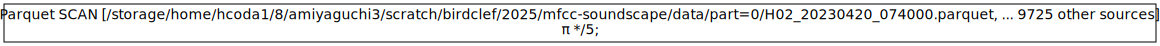

In [23]:
import polars as pl
import numpy as np

df = pl.scan_parquet("~/scratch/birdclef/2025/mfcc-soundscape/data")
df.show_graph()

In [10]:
# polars count the total number of elements
display(df.count().collect())
# how many different distinct files?
display(df.select(pl.col("file").n_unique()).collect())

index,file,timestamp,mfcc,part
u32,u32,u32,u32,u32
4658754,4658754,4658754,4658754,4658754


file
u32
9726


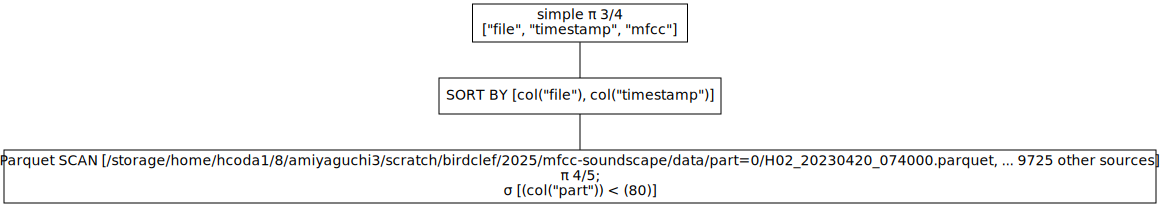

In [ ]:
subset = (
    df.filter(pl.col("part") < 80)
    .sort("file", "timestamp")
    .select("file", "timestamp", "mfcc")
)
subset.show_graph()

In [38]:
np.stack(subset.select("mfcc").collect().get_column("mfcc").to_numpy()).shape

(3729494, 20)

$$
298,359,520 bytes / (1024 * 1024 bytes/MiB) = 298,359,520 / 1,048,576 MiB \approx 284.5378 MiB
$$

In [ ]:
# let's do k-means directly
from sklearn.cluster import KMeans
from contexttimer import Timer

# number of clusters is going to be aligned to bytes
X = np.stack(subset.select("mfcc").collect().get_column("mfcc").to_numpy())
n_clusters = 2**8 - 1
with Timer() as t:
    print(
        f"Clustering {X.shape[0]} samples with {X.shape[1]} features into {n_clusters} clusters"
    )
    cluster = KMeans(n_clusters=n_clusters, random_state=0)
    cluster.fit(X)
print(f"Clustering took {t.elapsed:.2f} seconds")

Clustering 3729494 samples with 20 features into 255 clusters
Clustering took 121.87 seconds


In [ ]:
# let's do the same clustering with faisss
import faiss

cluster_faiss = faiss.Kmeans(
    d=X.shape[1], k=n_clusters, niter=300, nredo=3, verbose=True
)
with Timer() as t:
    print(
        f"Clustering {X.shape[0]} samples with {X.shape[1]} features into {n_clusters} clusters"
    )
    cluster_faiss.train(X.astype(np.float32))
print(f"Clustering took {t.elapsed:.2f} seconds")

Clustering 3729494 samples with 20 features into 255 clusters
Sampling a subset of 65280 / 3729494 for training
Clustering 65280 points in 20D to 255 clusters, redo 3 times, 300 iterations
  Preprocessing in 0.14 s
Outer iteration 0 / 3
  Iteration 299 (1.48 s, search 1.10 s): objective=0.000225352 imbalance=61.479 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 299 (2.93 s, search 2.19 s): objective=0.000250044 imbalance=58.204 nsplit=0       
Outer iteration 2 / 3
  Iteration 299 (4.30 s, search 3.24 s): objective=0.000222716 imbalance=49.367 nsplit=0       
Objective improved: keep new clusters
Clustering took 4.55 seconds


Faiss is 50x faster than sklearn for k-means clustering. Let's stick with this since it can also handle PCA.

Some things to consider:

- 3.7m / 65k ~ 57 samples per token
- need d to 2d samples for clusters

So instead of going to 60k, we can choose a smaller number of clusters. 2**14 will give us 16k clusters which should be alright for our purposes.

In [47]:
n_clusters = 2**14 - 1
cluster_faiss = faiss.Kmeans(d=X.shape[1], k=n_clusters, niter=25, verbose=True)
with Timer() as t:
    print(
        f"Clustering {X.shape[0]} samples with {X.shape[1]} features into {n_clusters} clusters"
    )
    cluster_faiss.train(X.astype(np.float32))
print(f"Clustering took {t.elapsed:.2f} seconds")

Clustering 3729494 samples with 20 features into 16383 clusters
Clustering 3729494 points in 20D to 16383 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.09 s
  Iteration 24 (156.76 s, search 155.58 s): objective=0.00690363 imbalance=1.306 nsplit=0       
Clustering took 156.95 seconds


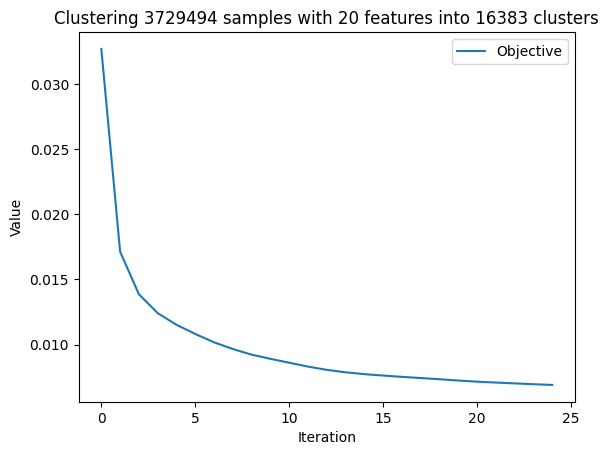

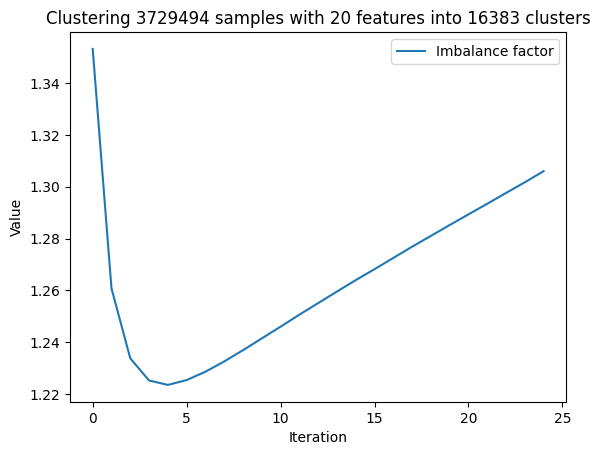

In [ ]:
# plot objective and imbalance
from matplotlib import pyplot as plt


def _metadata():
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.title(
        f"Clustering {X.shape[0]} samples with {X.shape[1]} features into {n_clusters} clusters"
    )


# cluster_faiss.iteration_stats

obj = [s["obj"] for s in cluster_faiss.iteration_stats]
imb = [s["imbalance_factor"] for s in cluster_faiss.iteration_stats]
plt.plot(obj, label="Objective")
_metadata()
plt.show()

plt.plot(imb, label="Imbalance factor")
_metadata()
plt.show()

Let's generate a plot of the support per token. What we do is for each token we count the number of samples we have for it and then plot the histogram for the counts.

In [ ]:
# get cluster assignments
index = faiss.IndexFlatL2(cluster_faiss.centroids.shape[1])
with Timer() as t:
    index.add(cluster_faiss.centroids)
print(f"Indexing took {t.elapsed:.2f} seconds")

with Timer() as t:
    _, indices = index.search(X, 1)
    cluster_ids = indices.flatten()
print(f"Searching took {t.elapsed:.2f} seconds")

Indexing took 0.00 seconds


Searching took 6.69 seconds


,cluster_id,len
0,6122,839
1,13688,815
2,1185,804
3,9798,802
4,4637,798


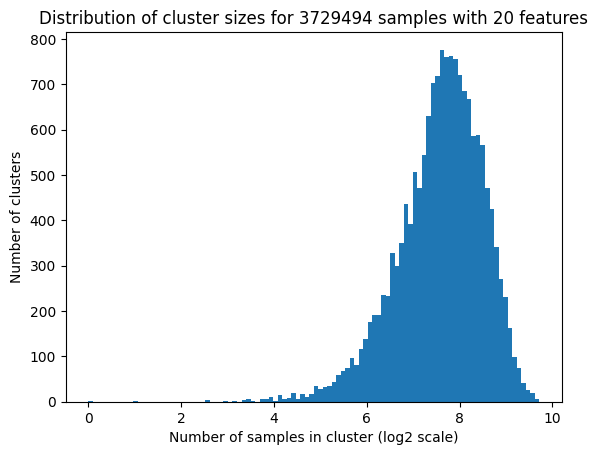

In [110]:
ids = pl.Series("cluster_id", cluster_ids)
subset_ids = subset.with_columns(ids).cache()
# groupby cluster_id and count the samples
freq = (
    (subset_ids.group_by("cluster_id").agg(pl.len()).sort("len", descending=True))
    .collect()
    .to_pandas()
)

display(freq.head(5))

# now let's plot a histogram
plt.hist(np.log2(freq["len"]), bins=100)
plt.xlabel("Number of samples in cluster (log2 scale)")
plt.ylabel("Number of clusters")
plt.title(
    f"Distribution of cluster sizes for {X.shape[0]} samples with {X.shape[1]} features"
)
plt.show()

Let's repeat this experiment, but now use PCA to reduce the dimensionality of the data before clustering. Let's go from 20 dimensions to however many we need to get 90% reconstruction of the variance.

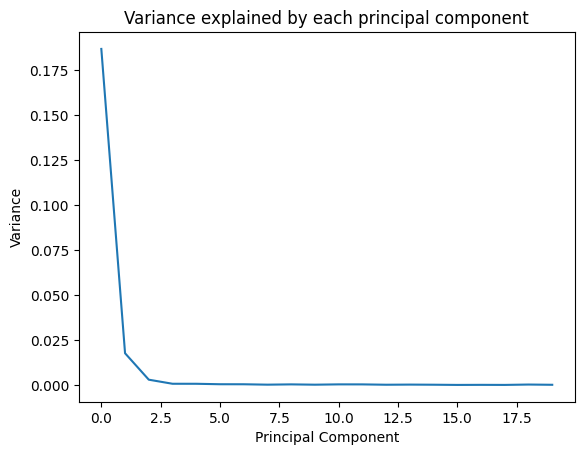

In [83]:
pca = faiss.PCAMatrix(20, 20)
pca.train(X)
tr = pca.apply(X)
plt.plot((tr**2).sum(0))
plt.xlabel("Principal Component")
plt.ylabel("Variance")
plt.title("Variance explained by each principal component")
plt.show()

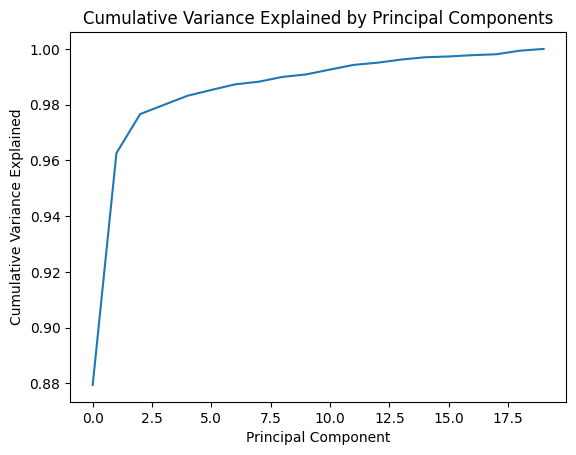

In [87]:
mag = (tr**2).sum(0)
ratio = mag / mag.sum()
plt.plot(ratio.cumsum())
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by Principal Components")
plt.show()

In [95]:
pca = faiss.PCAMatrix(20, 20)
pca.train(X)
tr = pca.apply(X)

n_clusters = 2**14 - 1
cluster_pca_faiss = faiss.Kmeans(d=tr.shape[1], k=n_clusters, niter=25, verbose=True)
with Timer() as t:
    print(
        f"Clustering {tr.shape[0]} samples with {tr.shape[1]} features into {n_clusters} clusters"
    )
    cluster_pca_faiss.train(tr)
print(f"Clustering took {t.elapsed:.2f} seconds")

Clustering 3729494 samples with 20 features into 16383 clusters
Clustering 3729494 points in 20D to 16383 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.09 s


  Iteration 24 (156.34 s, search 155.14 s): objective=0.00690359 imbalance=1.527 nsplit=0       
Clustering took 156.43 seconds


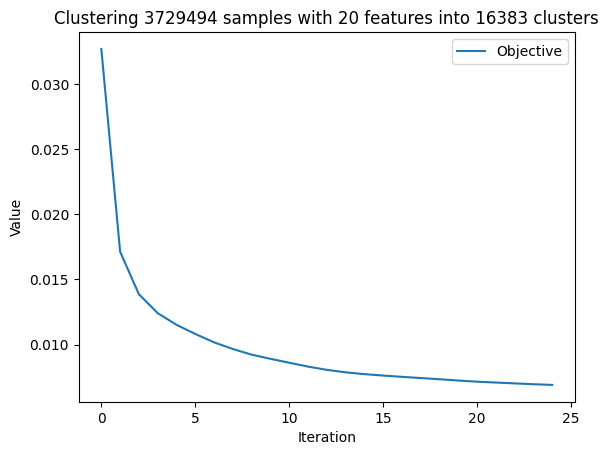

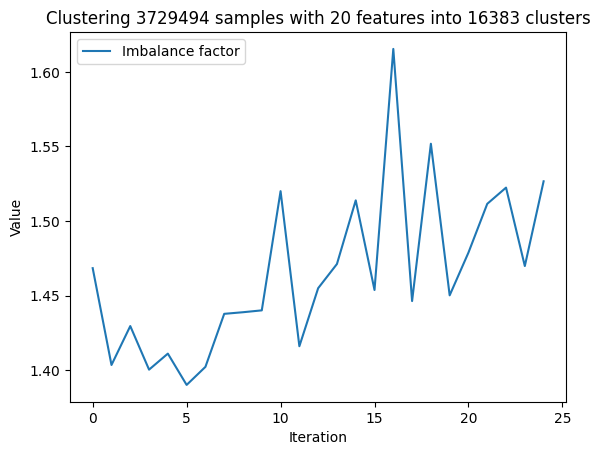

In [ ]:
def _metadata():
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.title(
        f"Clustering {tr.shape[0]} samples with {tr.shape[1]} features into {n_clusters} clusters"
    )


obj = [s["obj"] for s in cluster_pca_faiss.iteration_stats]
imb = [s["imbalance_factor"] for s in cluster_pca_faiss.iteration_stats]
plt.plot(obj, label="Objective")
_metadata()
plt.show()

plt.plot(imb, label="Imbalance factor")
_metadata()
plt.show()

In [ ]:
# get cluster assignments
index = faiss.IndexFlatL2(cluster_pca_faiss.centroids.shape[1])
with Timer() as t:
    index.add(cluster_pca_faiss.centroids)
print(f"Indexing took {t.elapsed:.2f} seconds")

with Timer() as t:
    _, indices = index.search(tr, 1)
    cluster_pca_ids = indices.flatten()
print(f"Searching took {t.elapsed:.2f} seconds")

Indexing took 0.00 seconds


Searching took 6.48 seconds


,cluster_id,len
0,145,7107
1,717,5557
2,10,4373
3,835,3750
4,361,3416


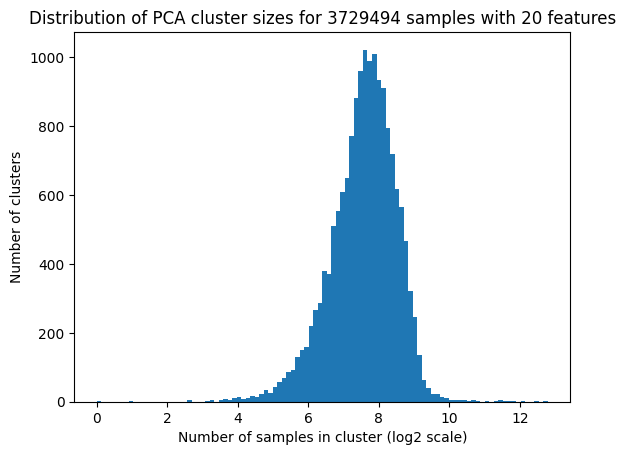

In [ ]:
ids = pl.Series("cluster_id", cluster_pca_ids)
subset_ids = subset.with_columns(ids).cache()
# groupby cluster_id and count the samples
freq_pca = (
    subset_ids.group_by("cluster_id")
    .agg(pl.len())
    .sort("len", descending=True)
    .collect()
    .to_pandas()
)

display(freq_pca.head(5))

# now let's plot a histogram
plt.hist(np.log2(freq_pca["len"]), bins=100)
plt.xlabel("Number of samples in cluster (log2 scale)")
plt.ylabel("Number of clusters")
plt.title(
    f"Distribution of PCA cluster sizes for {X.shape[0]} samples with {X.shape[1]} features"
)
plt.show()

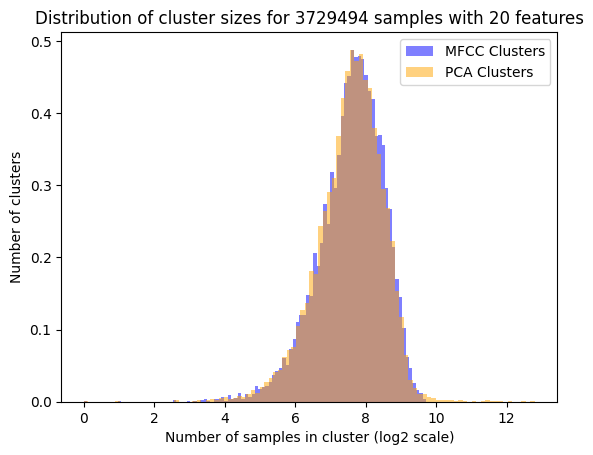

In [115]:
# now plot the two distributions over each other, freq and freq_pca
plt.hist(
    np.log2(freq["len"]),
    bins=100,
    alpha=0.5,
    label="MFCC Clusters",
    color="blue",
    density=True,
)
plt.hist(
    np.log2(freq_pca["len"]),
    bins=100,
    alpha=0.5,
    label="PCA Clusters",
    color="orange",
    density=True,
)
plt.xlabel("Number of samples in cluster (log2 scale)")
plt.ylabel("Number of clusters")
plt.title(
    f"Distribution of cluster sizes for {X.shape[0]} samples with {X.shape[1]} features"
)
plt.legend()
plt.show()